In [1]:
#versão da Linguagem Python
from platform import python_version
print('Versão da linguagem Python usada no ambiente virtual desse projeto:', python_version())

Versão da linguagem Python usada no ambiente virtual desse projeto: 3.12.3


In [3]:
# --- 1. CONFIGURAÇÃO DO AMBIENTE ---

from matplotlib.ticker import FuncFormatter
import pandas as pd
import numpy as np
import os
import sys
from statsmodels.tsa.api import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Configurações de visualização para os gráficos
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (18, 7)
plt.rcParams['font.size'] = 12

In [17]:
# --- IMPORTANTE: Altere a linha abaixo para o caminho do seu arquivo de dados original ---
caminho_do_arquivo = "/home/lucala/Residencia TJGO/tjgo/NLP/ENTREGAS FINAL/forecast/data/processed/dados_cível.csv"
# -----------------------------------------------------------------------------------------

try:
    print(f"Carregando o dataset principal de: {caminho_do_arquivo}")
    df_principal = pd.read_csv(caminho_do_arquivo)
    print("Dataset principal carregado com sucesso.")
    print(f"Total de {df_principal.shape[0]:,} registros carregados.")
except FileNotFoundError:
    print(f"ERRO CRÍTICO: O arquivo original não foi encontrado em '{caminho_do_arquivo}'.")
    print("Por favor, corrija o caminho na célula acima e execute-a novamente.")
    df_principal = None 
except Exception as e:
    print(f"Ocorreu um erro inesperado ao carregar o arquivo principal: {e}")
    df_principal = None

Carregando o dataset principal de: /home/lucala/Residencia TJGO/tjgo/NLP/ENTREGAS FINAL/forecast/data/processed/dados_cível.csv
Dataset principal carregado com sucesso.
Total de 3,872,329 registros carregados.


In [24]:
# 1.1. Verificação inicial do DataFrame
print("Informações Gerais do DataFrame:")
df_principal.info()

# 1.2. Quantidade de dados
print(f"\nO dataset possui {df_principal.shape[0]:,} linhas e {df_principal.shape[1]} colunas.")

# 1.3. Visualização das primeiras linhas
print("\n5 Primeiras Linhas do Dataset:")
display(df_principal.head())

# 1.4. Visualização das últimas linhas para garantir a integridade
print("\n5 Últimas Linhas do Dataset:")
display(df_principal.tail())

Informações Gerais do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3872329 entries, 0 to 3872328
Data columns (total 11 columns):
 #   Column            Dtype  
---  ------            -----  
 0   NUMERO            object 
 1   DATA_RECEBIMENTO  object 
 2   PRIORIDADE        object 
 3   SEGREDO_JUSTICA   bool   
 4   SERVENTIA         object 
 5   COMARCA           object 
 6   CLASSE            float64
 7   ASSUNTOS          object 
 8   PROC_STATUS       object 
 9   AREA_ACAO         object 
 10  VALOR_CAUSA       float64
dtypes: bool(1), float64(2), object(8)
memory usage: 299.1+ MB

O dataset possui 3,872,329 linhas e 11 colunas.

5 Primeiras Linhas do Dataset:


,NUMERO,DATA_RECEBIMENTO,PRIORIDADE,SEGREDO_JUSTICA,SERVENTIA,COMARCA,CLASSE,ASSUNTOS,PROC_STATUS,AREA_ACAO,VALOR_CAUSA
0,5437812-73.2014.8.09.0012,2014-01-01 00:00:00,Pedido de Tutela Provisória,True,Aparecida de Goiânia - UPJ Juizados Especiais ...,APARECIDA DE GOIÂNIA,436.0,10433,Arquivado,Cível,27000.0
1,5437815-23.2014.8.09.0046,2014-01-01 00:00:00,Normal,True,Formoso - Juizado Especial Cível,FORMOSO,436.0,7779,Arquivado,Cível,13560.0
2,5437811-37.2014.8.09.0029,2014-01-01 00:00:00,Normal,True,Catalão - UPJ Juizados Especiais Cíveis - 1º e 2º,CATALÃO,436.0,"7779,10433",Arquivado,Cível,7000.0
3,5437810-04.2014.8.09.0045,2014-01-01 00:00:00,Normal,True,Formosa - Juizado Especial Cível,FORMOSA,436.0,"7715,7779,7780,10433,10671",Arquivado,Cível,24304.0
4,5437809-68.2014.8.09.0061,2014-01-01 00:00:00,Normal,True,Goiânia - 1ª UPJ Juizados Especiais Cíveis: 1º...,GOIÂNIA,436.0,"7779,7780",Arquivado,Cível,24000.0



5 Últimas Linhas do Dataset:


,NUMERO,DATA_RECEBIMENTO,PRIORIDADE,SEGREDO_JUSTICA,SERVENTIA,COMARCA,CLASSE,ASSUNTOS,PROC_STATUS,AREA_ACAO,VALOR_CAUSA
3872324,5698797-23.2022.8.09.0051,2022-11-15 00:00:00,Normal,True,Goiânia - UPJ Varas da Fazenda Pública Estadua...,GOIÂNIA,12078.0,"10303,13385,13537,10656",Ativo,Cível,132745.0
3872325,5698795-48.2022.8.09.0085,2022-11-15 00:00:00,Normal,True,Itapuranga - Juizado das Fazendas Públicas,ITAPURANGA,156.0,14201,Arquivado,Cível,15258.0
3872326,5698792-36.2022.8.09.0007,2022-11-15 00:00:00,Pedido de Tutela Provisória,True,Anápolis - 1º Juizado Especial Cível,ANÁPOLIS,436.0,"6226,7711,10671",Arquivado,Cível,7460.0
3872327,5698790-50.2022.8.09.0174,2022-11-15 00:00:00,Normal,True,Senador Canedo - 1ª Vara Cível,SENADOR CANEDO,49.0,10458,Arquivado,Cível,192000.0
3872328,5698849-16.2022.8.09.0149,2022-11-15 00:00:00,Normal,True,Trindade - Vara das Fazendas Públicas - Execuç...,TRINDADE,1116.0,5952,Arquivado,Cível,1053.0


In [22]:
def realizar_analise_compreensao(dataframe, nome_da_area):
    """
    Função que executa todas as etapas da fase de Compreensão de Dados em um DataFrame.
    
    Args:
        dataframe (pd.DataFrame): O DataFrame a ser analisado.
        nome_da_area (str): O nome da Área de Ação para usar nos títulos.
    """
    df = dataframe.copy() # Cria uma cópia para evitar alterar o DataFrame original

    print("\n" + "="*80)
    print(f"INICIANDO ANÁLISE PARA A ÁREA: {nome_da_area.upper()}")
    print("="*80 + "\n")

    # 1. DESCRIÇÃO DOS DADOS
    print(f"--- 1. Descrição dos Dados ({nome_da_area}) ---")
    print(f"O dataset possui {df.shape[0]:,} linhas e {df.shape[1]} colunas.")
    print("Amostra dos dados:")
    display(df.head())

    # 2. VERIFICAÇÃO DA QUALIDADE DOS DADOS
    print(f"\n--- 2. Verificação da Qualidade dos Dados ({nome_da_area}) ---")
    missing_values = df.isnull().sum()
    print("Contagem de Valores Ausentes:")
    if missing_values.sum() > 0:
        missing_df = pd.DataFrame({'Contagem Ausente': missing_values[missing_values > 0],
                                   'Percentual Ausente (%)': (missing_values[missing_values > 0] / len(df)) * 100})
        display(missing_df.sort_values(by='Contagem Ausente', ascending=False))
    else:
        print("Nenhum valor ausente encontrado.")
    print(f"\nNúmero de linhas duplicadas: {df.duplicated().sum()}")

    # 3. EXPLORAÇÃO DOS DADOS
    print(f"\n--- 3. Exploração dos Dados ({nome_da_area}) ---")
    print("\nAnalisando a série temporal de novos casos...")
    df['DATA_RECEBIMENTO_DT'] = pd.to_datetime(df['DATA_RECEBIMENTO'], errors='coerce')
    df.dropna(subset=['DATA_RECEBIMENTO_DT'], inplace=True)
    df.set_index('DATA_RECEBIMENTO_DT', inplace=True)
    df.sort_index(inplace=True)

    casos_por_mes = df.resample('M').size()
    plt.figure(figsize=(18, 6))
    casos_por_mes.plot(title=f'Novos Casos por Mês - ÁREA: {nome_da_area}')
    plt.xlabel('Data de Recebimento')
    plt.ylabel('Quantidade de Casos')
    plt.tight_layout()
    plt.show()

    def plot_top_n_area(data, column, n, title_suffix=''):
        plt.figure(figsize=(12, 6))
        top_n = data[column].astype(str).value_counts().nlargest(n)
        sns.barplot(x=top_n.values, y=top_n.index, palette='viridis', orient='h')
        plt.title(f'Top {n} {column} - ÁREA: {title_suffix}')
        plt.xlabel('Contagem')
        plt.ylabel(column)
        plt.tight_layout()
        plt.show()

    print("\nAnalisando as principais variáveis categóricas...")
    plot_top_n_area(df, 'COMARCA', n=15, title_suffix=nome_da_area)
    plot_top_n_area(df, 'ASSUNTOS', n=20, title_suffix=nome_da_area)
    plot_top_n_area(df, 'CLASSE', n=15, title_suffix=nome_da_area)

    print("\nAnalisando a variável numérica VALOR_CAUSA...")
    df['VALOR_CAUSA'].fillna(0, inplace=True)
    # LINHA CORRIGIDA ABAIXO
    df['LOG_VALOR_CAUSA'] = np.log1p(df['VALOR_CAUSA'])
    plt.figure(figsize=(14, 6))
    sns.histplot(df['LOG_VALOR_CAUSA'], bins=50, kde=True)
    plt.title(f'Distribuição do Log(Valor da Causa) - ÁREA: {nome_da_area}')
    plt.tight_layout()
    plt.show()
    
    print(f"\n--- FIM DA ANÁLISE PARA A ÁREA: {nome_da_area.upper()} ---")

print("Função 'realizar_analise_compreensao' definida com sucesso.")

Função 'realizar_analise_compreensao' definida com sucesso.



INICIANDO ANÁLISE PARA A ÁREA: CÍVEL

--- 1. Descrição dos Dados (Cível) ---
O dataset possui 3,872,329 linhas e 11 colunas.
Amostra dos dados:


,NUMERO,DATA_RECEBIMENTO,PRIORIDADE,SEGREDO_JUSTICA,SERVENTIA,COMARCA,CLASSE,ASSUNTOS,PROC_STATUS,AREA_ACAO,VALOR_CAUSA
0,5437812-73.2014.8.09.0012,2014-01-01 00:00:00,Pedido de Tutela Provisória,True,Aparecida de Goiânia - UPJ Juizados Especiais ...,APARECIDA DE GOIÂNIA,436.0,10433,Arquivado,Cível,27000.0
1,5437815-23.2014.8.09.0046,2014-01-01 00:00:00,Normal,True,Formoso - Juizado Especial Cível,FORMOSO,436.0,7779,Arquivado,Cível,13560.0
2,5437811-37.2014.8.09.0029,2014-01-01 00:00:00,Normal,True,Catalão - UPJ Juizados Especiais Cíveis - 1º e 2º,CATALÃO,436.0,"7779,10433",Arquivado,Cível,7000.0
3,5437810-04.2014.8.09.0045,2014-01-01 00:00:00,Normal,True,Formosa - Juizado Especial Cível,FORMOSA,436.0,"7715,7779,7780,10433,10671",Arquivado,Cível,24304.0
4,5437809-68.2014.8.09.0061,2014-01-01 00:00:00,Normal,True,Goiânia - 1ª UPJ Juizados Especiais Cíveis: 1º...,GOIÂNIA,436.0,"7779,7780",Arquivado,Cível,24000.0



--- 2. Verificação da Qualidade dos Dados (Cível) ---
Contagem de Valores Ausentes:


,Contagem Ausente,Percentual Ausente (%)
VALOR_CAUSA,762,0.019678
CLASSE,404,0.010433
ASSUNTOS,49,0.001265



Número de linhas duplicadas: 0

--- 3. Exploração dos Dados (Cível) ---

Analisando a série temporal de novos casos...


/tmp/ipykernel_7347/2561341678.py:41: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  casos_por_mes = df.resample('M').size()


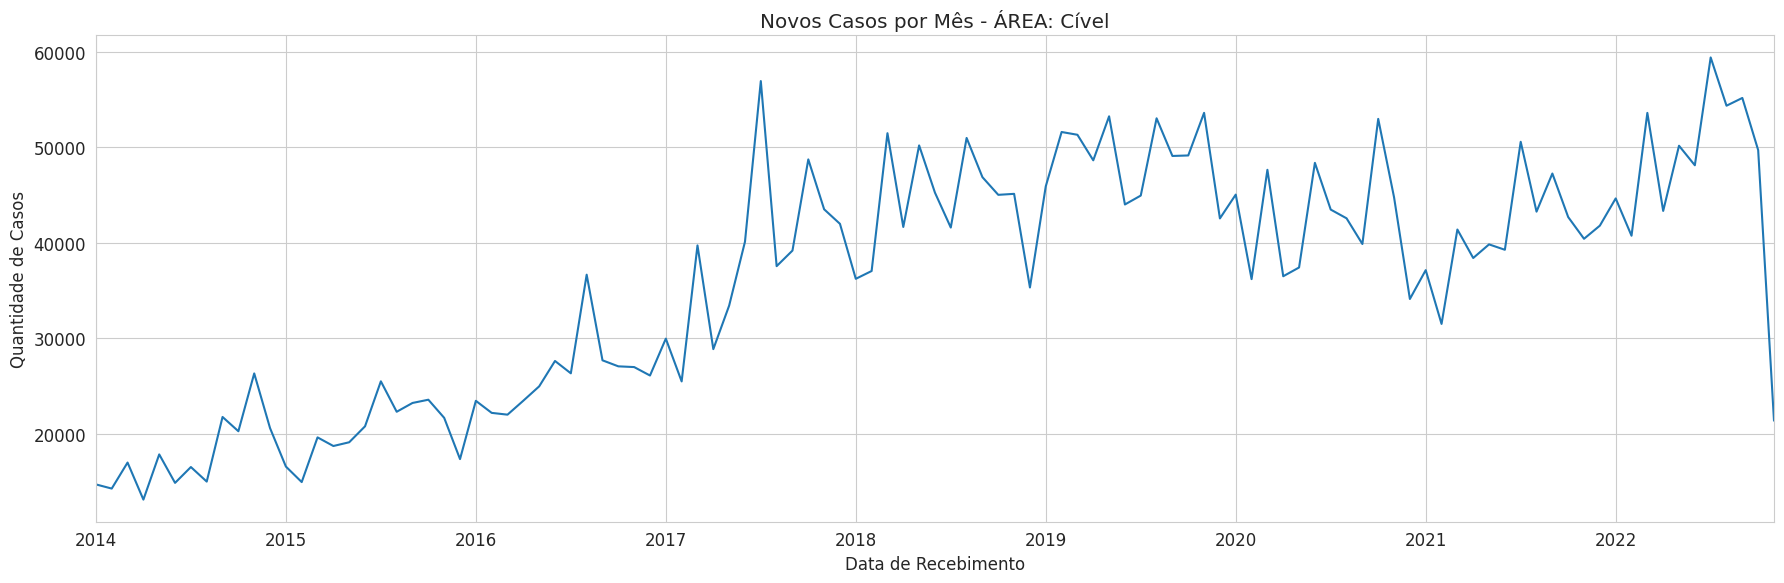


Analisando as principais variáveis categóricas...


/tmp/ipykernel_7347/2561341678.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_n.values, y=top_n.index, palette='viridis', orient='h')


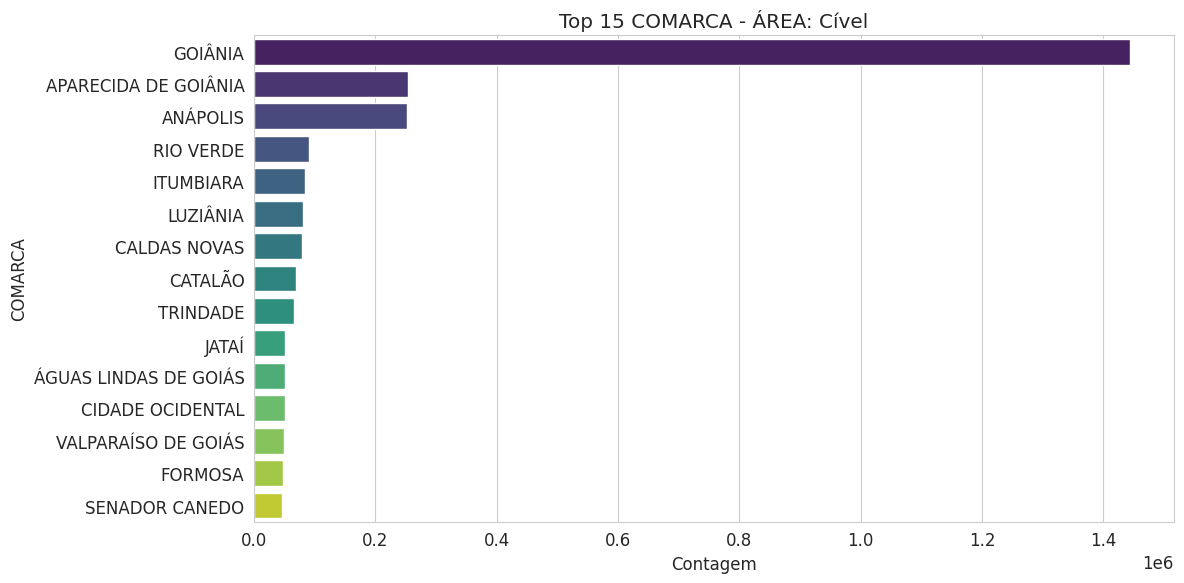

/tmp/ipykernel_7347/2561341678.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_n.values, y=top_n.index, palette='viridis', orient='h')


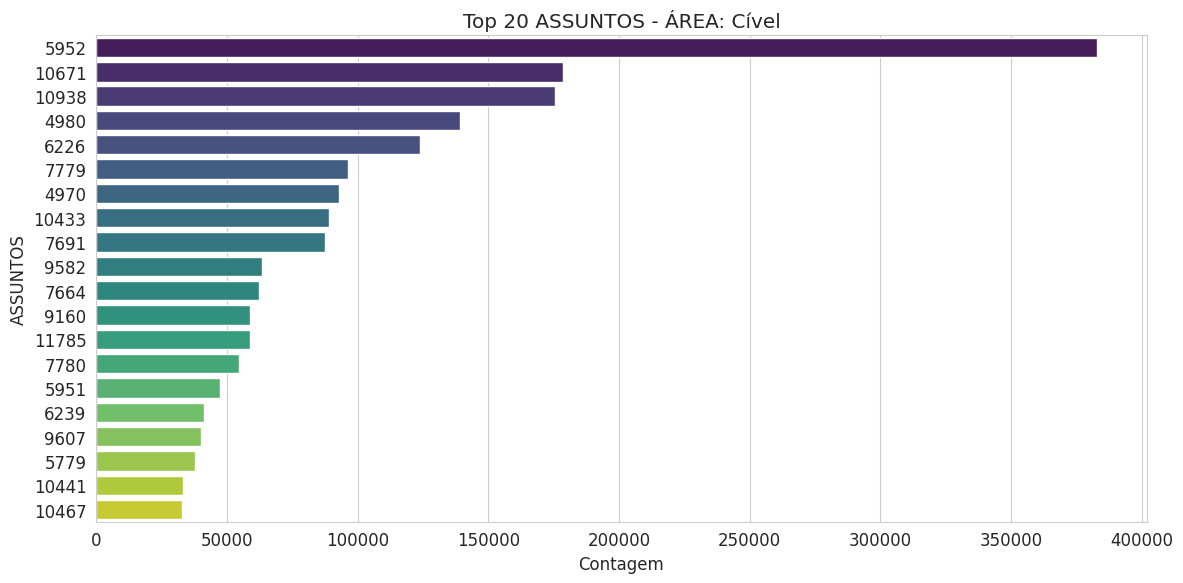

/tmp/ipykernel_7347/2561341678.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_n.values, y=top_n.index, palette='viridis', orient='h')


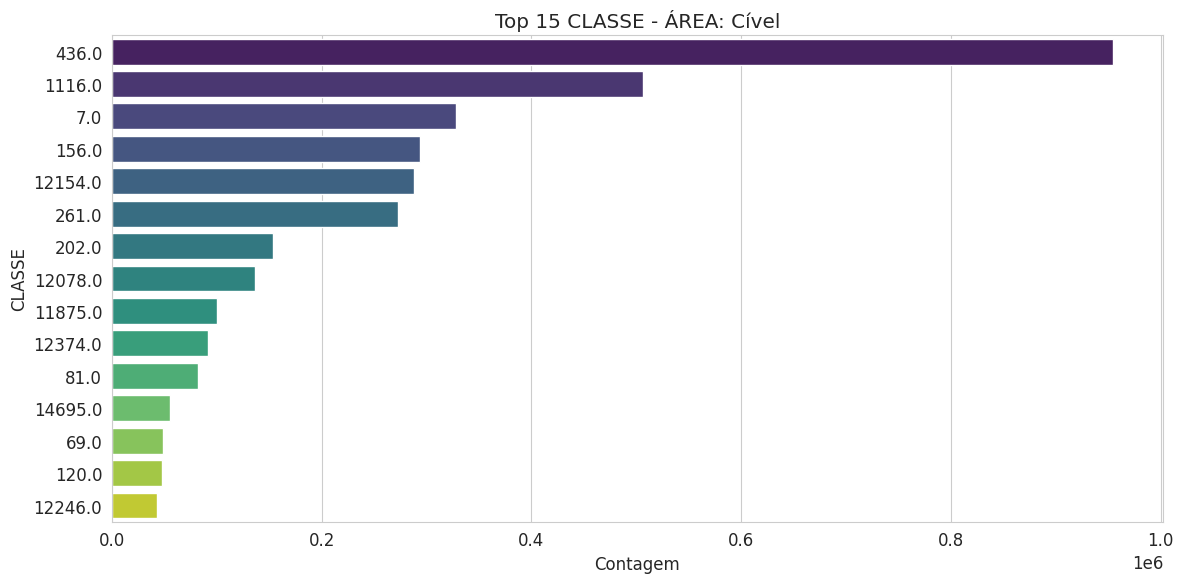

/tmp/ipykernel_7347/2561341678.py:65: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['VALOR_CAUSA'].fillna(0, inplace=True)



Analisando a variável numérica VALOR_CAUSA...


/home/lucala/Residencia TJGO/tjgo/NLP/ENTREGAS FINAL/forecast/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


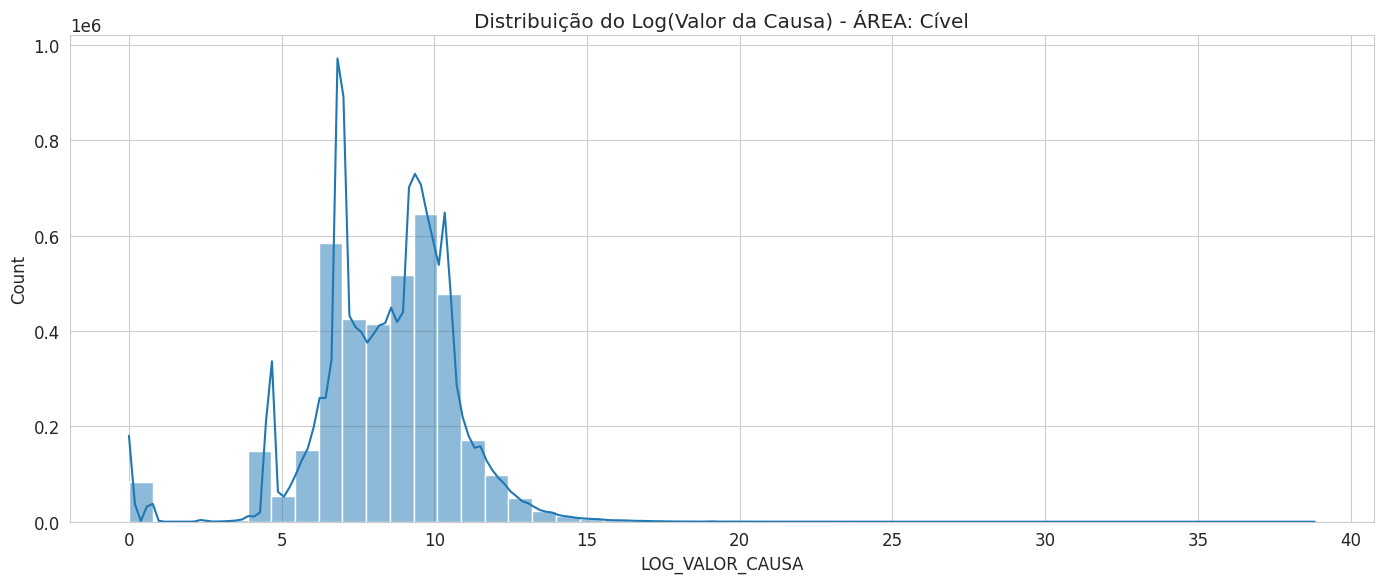


--- FIM DA ANÁLISE PARA A ÁREA: CÍVEL ---


In [23]:
# Verifica se o DataFrame df_principal existe e não está vazio antes de executar a análise
if 'df_principal' in locals() and df_principal is not None and not df_principal.empty:
    # Chama a função de análise, passando o DataFrame carregado
    realizar_analise_compreensao(dataframe=df_principal, nome_da_area='Cível')
else:
    print("A análise não pode ser executada. O DataFrame 'df_principal' não foi carregado ou está vazio.")
    print("Por favor, execute a célula de carregamento de dados primeiro.")

### Dicionário dos dados:


NUMERO: Identificador único do processo

DATA_RECEBIMENTO: Data em que o processo foi protocolado/recebido (variável alvo para a série temporal).

PRIORIDADE: Indica se o processo tem prioridade de tramitação (Categórico).

SEGREDO_JUSTICA: Indica se o processo corre em segredo de justiça (Booleano).

SERVENTIA: Unidade judiciária responsável (Vara, Cartório) (Categórico de alta cardinalidade).

COMARCA: Unidade territorial judiciária (Categórico de alta cardinalidade).

CLASSE: Código ou nome da classe processual (e.g., Ação Cível, Mandado de Segurança). Atualmente como float, precisa de investigação.

ASSUNTOS: Tema(s) legal(is) tratados no processo (Categórico, pode conter múltiplos valores).

PROC_STATUS: Status atual do processo (e.g., Ativo, Arquivado) (Categórico).

AREA_ACAO: Área do direito 

VALOR_CAUSA: Valor monetário atribuído à causa (Numérico).

/tmp/ipykernel_7347/1301959413.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  casos_por_mes = df_temp.resample('M').size()


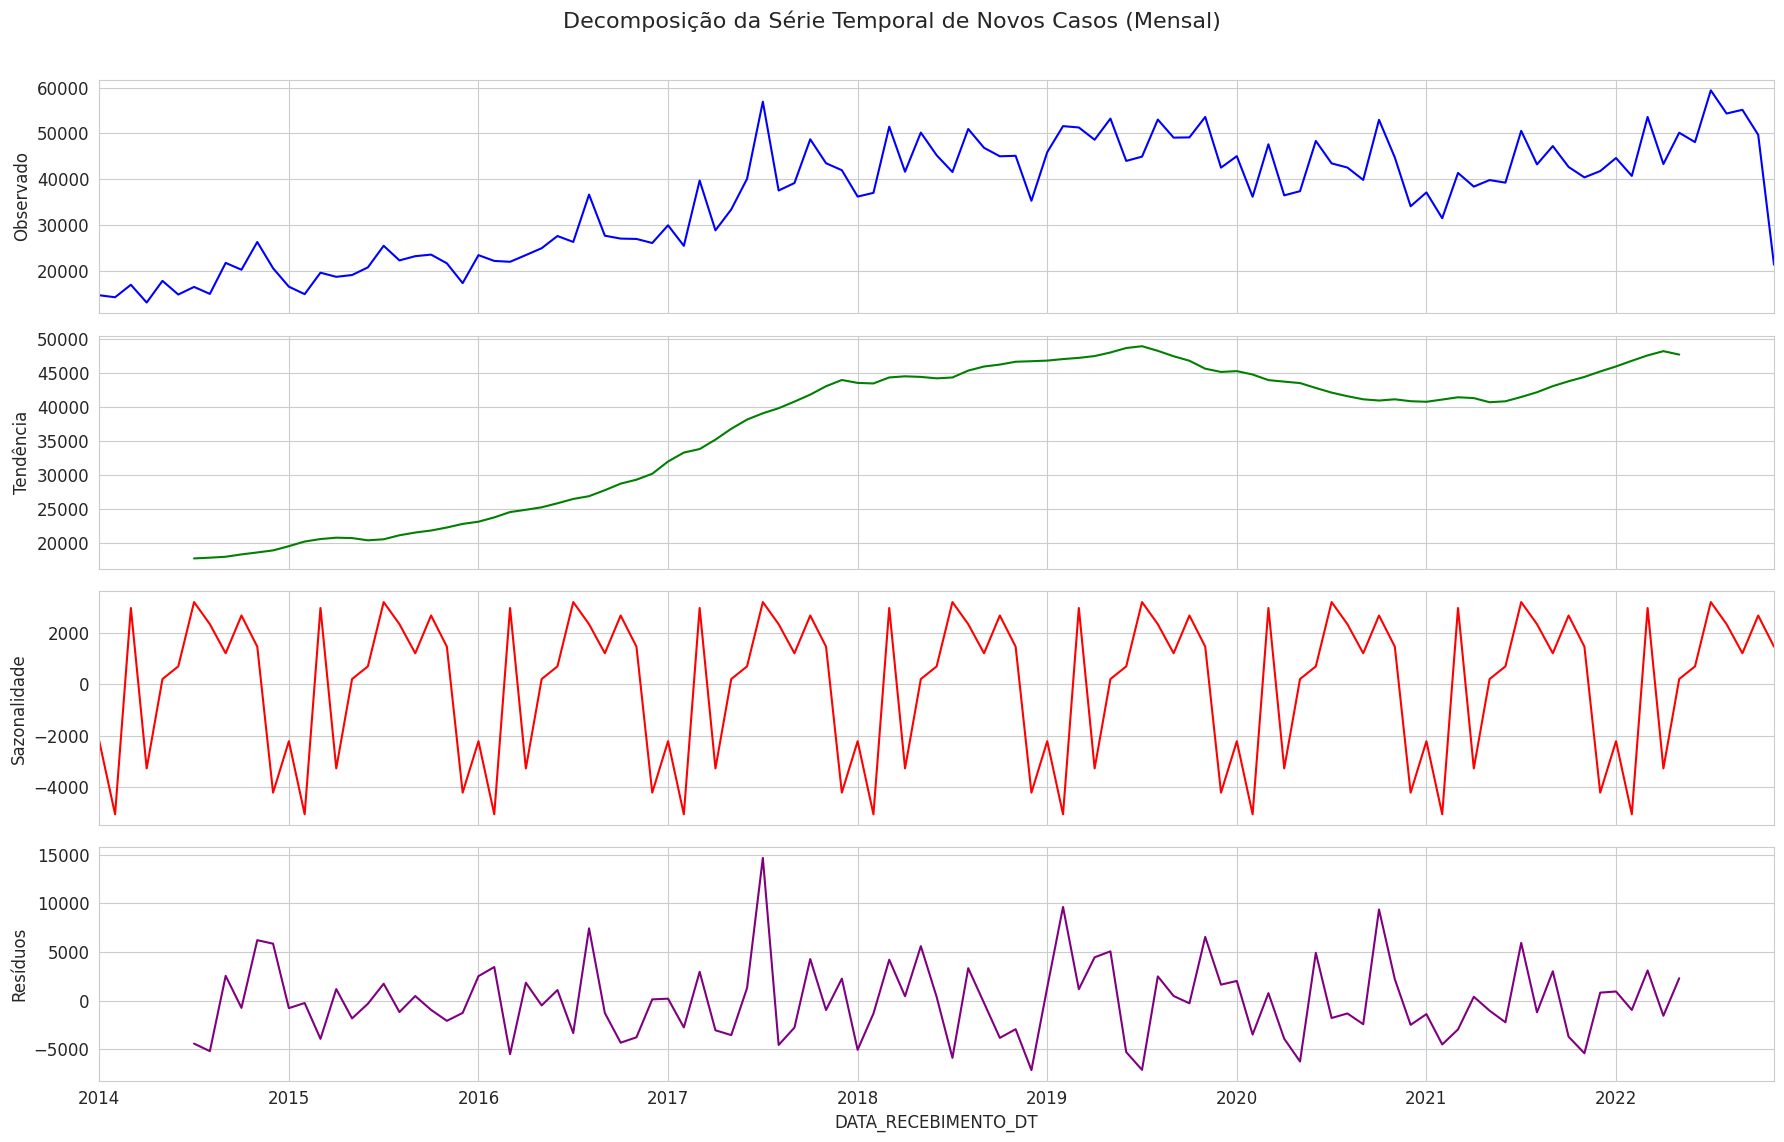

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Vamos usar os dados de casos por mês que já calculamos na função anterior
# Primeiro, precisamos recriar essa variável a partir do df_principal
df_temp = df_principal.copy()
df_temp['DATA_RECEBIMENTO_DT'] = pd.to_datetime(df_temp['DATA_RECEBIMENTO'], errors='coerce')
df_temp.dropna(subset=['DATA_RECEBIMENTO_DT'], inplace=True)
df_temp.set_index('DATA_RECEBIMENTO_DT', inplace=True)
casos_por_mes = df_temp.resample('M').size()

# A decomposição aditiva é uma boa primeira abordagem
# O período (period) é 12 porque esperamos um padrão que se repete anualmente (12 meses)
decomposicao = seasonal_decompose(casos_por_mes, model='additive', period=12)

# Plotando os componentes
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(18, 12), sharex=True)

decomposicao.observed.plot(ax=ax1, legend=False, color='b')
ax1.set_ylabel('Observado')
decomposicao.trend.plot(ax=ax2, legend=False, color='g')
ax2.set_ylabel('Tendência')
decomposicao.seasonal.plot(ax=ax3, legend=False, color='r')
ax3.set_ylabel('Sazonalidade')
decomposicao.resid.plot(ax=ax4, legend=False, color='purple')
ax4.set_ylabel('Resíduos')

plt.suptitle('Decomposição da Série Temporal de Novos Casos (Mensal)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

/tmp/ipykernel_7347/2846228249.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='MES', y='contagem_casos', data=df_diario, ax=axes[0], palette='viridis')
/tmp/ipykernel_7347/2846228249.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='DIA_DA_SEMANA', data=df_temp, ax=axes[1], palette='plasma')


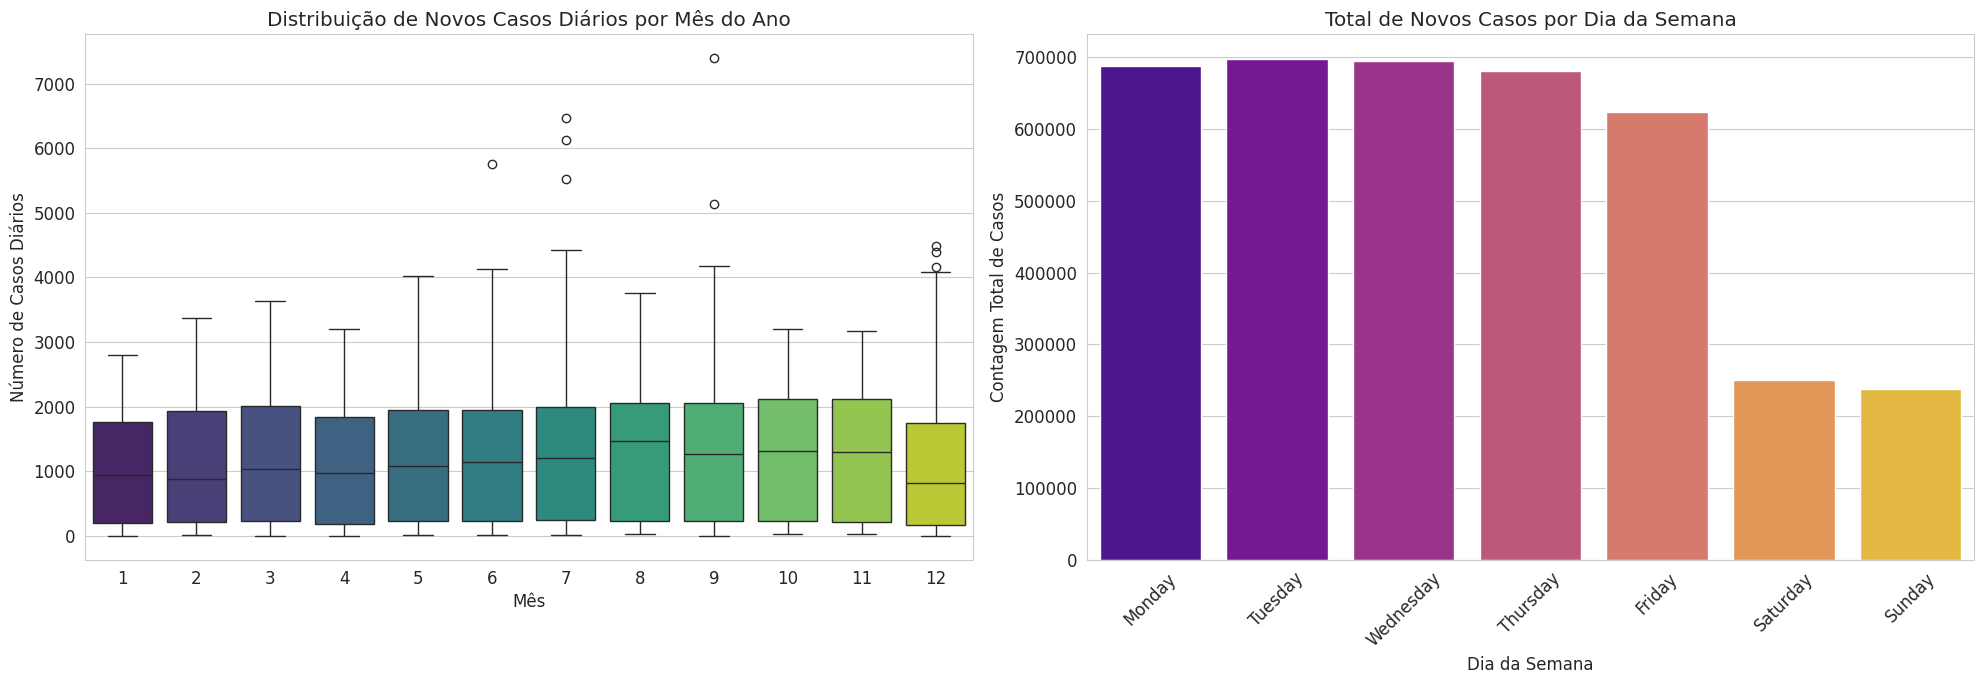

In [27]:
# Usando o DataFrame com o índice de data criado na célula anterior (df_temp)
df_temp['ANO'] = df_temp.index.year
df_temp['MES'] = df_temp.index.month
df_temp['DIA_DA_SEMANA'] = df_temp.index.day_name()

# --- INÍCIO DA CORREÇÃO ---

# 1. Criar um novo DataFrame com a contagem de casos por dia.
casos_diarios = df_temp.resample('D').size()
df_diario = casos_diarios.to_frame(name='contagem_casos')

# 2. Extrair o mês a partir do índice diário.
df_diario['MES'] = df_diario.index.month

# --- FIM DA CORREÇÃO ---


# Gráfico 1: Média de casos por mês do ano (usando o novo df_diario)
fig, axes = plt.subplots(1, 2, figsize=(20, 7))
sns.boxplot(x='MES', y='contagem_casos', data=df_diario, ax=axes[0], palette='viridis')
axes[0].set_title('Distribuição de Novos Casos Diários por Mês do Ano')
axes[0].set_xlabel('Mês')
axes[0].set_ylabel('Número de Casos Diários')

# Gráfico 2: Total de casos por dia da semana (esta parte já estava correta)
dias_ordenados = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_temp['DIA_DA_SEMANA'] = pd.Categorical(df_temp['DIA_DA_SEMANA'], categories=dias_ordenados, ordered=True)
sns.countplot(x='DIA_DA_SEMANA', data=df_temp, ax=axes[1], palette='plasma')
axes[1].set_title('Total de Novos Casos por Dia da Semana')
axes[1].set_xlabel('Dia da Semana')
axes[1].set_ylabel('Contagem Total de Casos')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Analisando as 5 principais comarcas: ['GOIÂNIA', 'APARECIDA DE GOIÂNIA', 'ANÁPOLIS', 'RIO VERDE', 'ITUMBIARA']


/tmp/ipykernel_7347/1338334569.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  casos_por_mes_comarca = df_top_comarcas.groupby([pd.Grouper(freq='M'), 'COMARCA']).size().unstack()


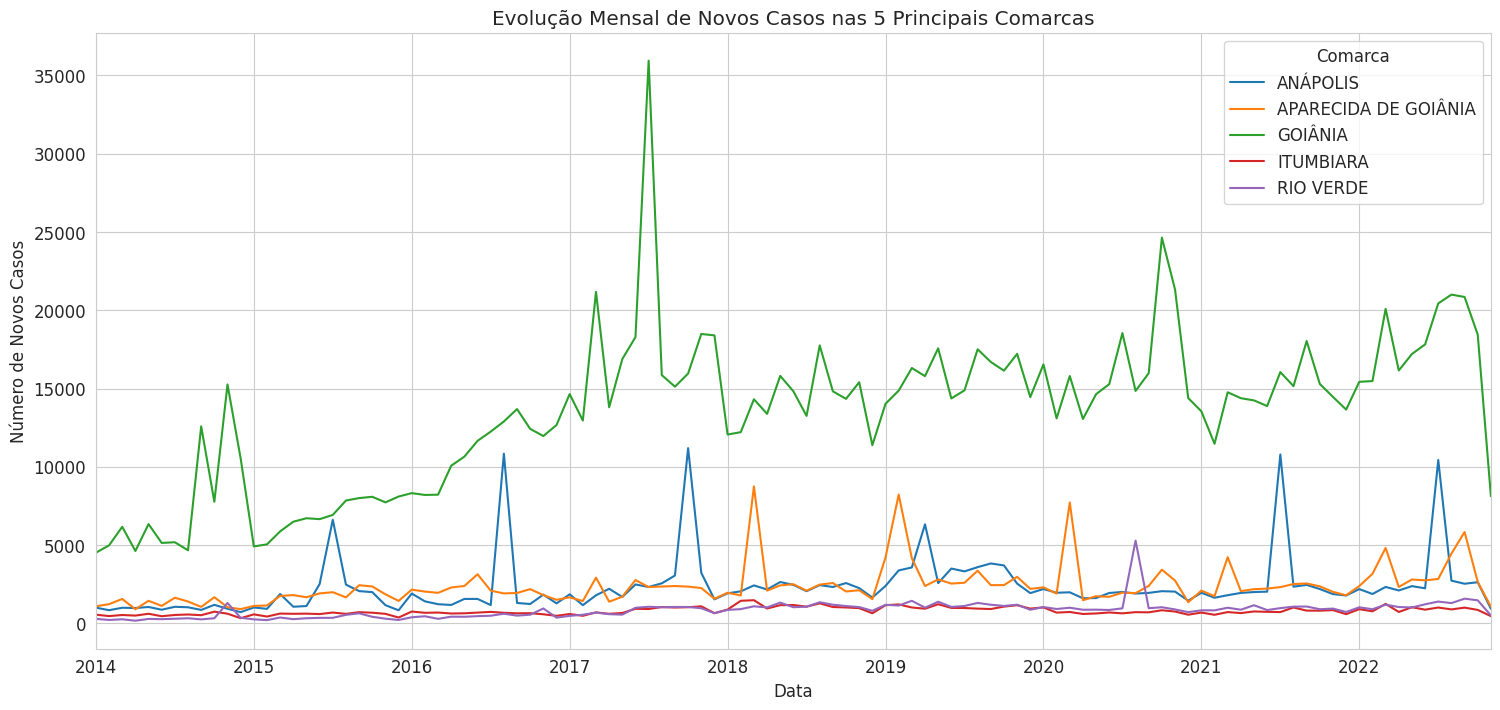

In [28]:
# Identificar as 5 comarcas com mais processos
top_5_comarcas = df_temp['COMARCA'].value_counts().nlargest(5).index.tolist()
print(f"Analisando as 5 principais comarcas: {top_5_comarcas}")

# Filtrar o DataFrame para conter apenas dados dessas comarcas
df_top_comarcas = df_temp[df_temp['COMARCA'].isin(top_5_comarcas)]

# Agrupar por mês e por comarca para criar as séries temporais
casos_por_mes_comarca = df_top_comarcas.groupby([pd.Grouper(freq='M'), 'COMARCA']).size().unstack()

# Plotar as séries temporais
plt.figure(figsize=(18, 8))
casos_por_mes_comarca.plot(ax=plt.gca())
plt.title('Evolução Mensal de Novos Casos nas 5 Principais Comarcas')
plt.xlabel('Data')
plt.ylabel('Número de Novos Casos')
plt.legend(title='Comarca')
plt.show()

In [4]:
# Carregar o dataset da área cível novamente, caso o notebook tenha sido reiniciado
caminho_arquivo_civel = "/home/lucala/Residencia TJGO/tjgo/NLP/ENTREGAS FINAL/forecast/data/processed/dados_cível.csv"
df = pd.read_csv(caminho_arquivo_civel)

print("Dataset original carregado.")
print(f"Número de linhas: {df.shape[0]:,}")

# --- 1. Seleção de Dados ---
# Para a previsão de novos casos, não precisaremos do número único do processo.
# A área de ação é constante ('Cível'), então também pode ser removida.
colunas_para_remover = ['NUMERO', 'AREA_ACAO']
df.drop(columns=colunas_para_remover, inplace=True)
print(f"\nColunas {colunas_para_remover} removidas.")

# --- 2. Limpeza de Dados ---

# 2.1 Corrigir o tipo da coluna de data (passo mais crítico)
# Conforme identificado, ela está como 'object' e precisa ser 'datetime'
df['DATA_RECEBIMENTO'] = pd.to_datetime(df['DATA_RECEBIMENTO'], errors='coerce')

# Remover quaisquer linhas onde a data não pôde ser convertida
df.dropna(subset=['DATA_RECEBIMENTO'], inplace=True)
print("Coluna 'DATA_RECEBIMENTO' convertida para datetime.")

# 2.2 Tratar valores ausentes nas colunas CLASSE, ASSUNTOS e VALOR_CAUSA
# Com base na análise anterior, a quantidade é mínima, então a imputação simples é segura.

# Para colunas categóricas, preenchemos com um marcador 'NA' (Não Aplicável)
df['CLASSE'].fillna('NA', inplace=True)
df['ASSUNTOS'].fillna('NA', inplace=True)

# Para VALOR_CAUSA, preencher com 0 é uma abordagem razoável.
df['VALOR_CAUSA'].fillna(0, inplace=True)
print("Valores ausentes tratados.")

# 2.3 Corrigir o tipo da coluna CLASSE
# Ela foi carregada como float por causa dos NaNs. Agora convertemos para string.
df['CLASSE'] = df['CLASSE'].astype(str)
print("Coluna 'CLASSE' convertida para string.")


# Verificar o resultado das limpezas
print("\nInformações do DataFrame após limpeza inicial:")
df.info()

print(f"\nTotal de valores ausentes restantes: {df.isnull().sum().sum()}")

Dataset original carregado.
Número de linhas: 3,872,329

Colunas ['NUMERO', 'AREA_ACAO'] removidas.
Coluna 'DATA_RECEBIMENTO' convertida para datetime.


/tmp/ipykernel_50461/3688298514.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['CLASSE'].fillna('NA', inplace=True)
/tmp/ipykernel_50461/3688298514.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'NA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df['CLASSE'].fillna('NA', inplace=True)
/tmp/ipykernel_50461/3688298514.py:30: FutureWarning: A value is trying to be set on a copy of a DataFra

Valores ausentes tratados.
Coluna 'CLASSE' convertida para string.

Informações do DataFrame após limpeza inicial:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3872329 entries, 0 to 3872328
Data columns (total 9 columns):
 #   Column            Dtype         
---  ------            -----         
 0   DATA_RECEBIMENTO  datetime64[ns]
 1   PRIORIDADE        object        
 2   SEGREDO_JUSTICA   bool          
 3   SERVENTIA         object        
 4   COMARCA           object        
 5   CLASSE            object        
 6   ASSUNTOS          object        
 7   PROC_STATUS       object        
 8   VALOR_CAUSA       float64       
dtypes: bool(1), datetime64[ns](1), float64(1), object(6)
memory usage: 240.0+ MB

Total de valores ausentes restantes: 0


In [7]:
# Garantir que o índice seja a coluna de data
df = df.set_index('DATA_RECEBIMENTO')

# Criar features baseadas no índice de data
df['ano'] = df.index.year
df['mes'] = df.index.month
df['dia_do_mes'] = df.index.day
df['dia_da_semana'] = df.index.dayofweek  # Segunda=0, Domingo=6
df['dia_do_ano'] = df.index.dayofyear
df['semana_do_ano'] = df.index.isocalendar().week.astype(int)
df['trimestre'] = df.index.quarter
df['inicio_do_mes'] = df.index.is_month_start.astype(int)
df['fim_do_mes'] = df.index.is_month_end.astype(int)

print("Features de calendário criadas:")
display(df.head())

Features de calendário criadas:


,PRIORIDADE,SEGREDO_JUSTICA,SERVENTIA,COMARCA,CLASSE,ASSUNTOS,PROC_STATUS,VALOR_CAUSA,ano,mes,dia_do_mes,dia_da_semana,dia_do_ano,semana_do_ano,trimestre,inicio_do_mes,fim_do_mes
DATA_RECEBIMENTO,,,,,,,,,,,,,,,,,
2014-01-01,Pedido de Tutela Provisória,True,Aparecida de Goiânia - UPJ Juizados Especiais ...,APARECIDA DE GOIÂNIA,436.0,10433,Arquivado,27000.0,2014,1,1,2,1,1,1,1,0
2014-01-01,Normal,True,Formoso - Juizado Especial Cível,FORMOSO,436.0,7779,Arquivado,13560.0,2014,1,1,2,1,1,1,1,0
2014-01-01,Normal,True,Catalão - UPJ Juizados Especiais Cíveis - 1º e 2º,CATALÃO,436.0,"7779,10433",Arquivado,7000.0,2014,1,1,2,1,1,1,1,0
2014-01-01,Normal,True,Formosa - Juizado Especial Cível,FORMOSA,436.0,"7715,7779,7780,10433,10671",Arquivado,24304.0,2014,1,1,2,1,1,1,1,0
2014-01-01,Normal,True,Goiânia - 1ª UPJ Juizados Especiais Cíveis: 1º...,GOIÂNIA,436.0,"7779,7780",Arquivado,24000.0,2014,1,1,2,1,1,1,1,0


In [22]:
# Importar pandas para a recriação do arquivo
import pandas as pd

# Carregar o dataset original (não o preparado)
caminho_original = "/home/lucala/Residencia TJGO/tjgo/NLP/ENTREGAS FINAL/forecast/data/processed/dados_cível.csv"
df_original = pd.read_csv(caminho_original)

# Converter a data para o formato datetime
df_original['DATA_RECEBIMENTO'] = pd.to_datetime(df_original['DATA_RECEBIMENTO'], errors='coerce')
df_original.dropna(subset=['DATA_RECEBIMENTO'], inplace=True)

# Definir a data como índice
df_original.set_index('DATA_RECEBIMENTO', inplace=True)

# Criar a série temporal MENSAL, garantindo o nome da coluna
casos_por_mes = df_original.resample('M').size()
df_mensal_corrigido = casos_por_mes.to_frame(name='contagem_casos')  # Garante o nome correto aqui

# Recriar as features de calendário (agora mensais)
df_mensal_corrigido['ano'] = df_mensal_corrigido.index.year
df_mensal_corrigido['mes'] = df_mensal_corrigido.index.month
# Para dados mensais, o dia do mês não faz sentido, então podemos remover
# df_mensal_corrigido['dia_do_mes'] = df_mensal_corrigido.index.day
# df_mensal_corrigido['dia_da_semana'] = df_mensal_corrigido.index.dayofweek

# Adicionar trimestre como feature adicional útil para dados mensais
df_mensal_corrigido['trimestre'] = df_mensal_corrigido.index.quarter

# Salvar o arquivo preparado novamente, agora com dados mensais
caminho_arquivo_preparado = "/home/lucala/Residencia TJGO/tjgo/NLP/ENTREGAS FINAL/forecast/data/processed/dados_civel_preparado.csv"
df_mensal_corrigido.to_csv(caminho_arquivo_preparado)

print("Arquivo 'dados_civel_preparado.csv' recriado com dados MENSAL e salvo com a estrutura correta.")
display(df_mensal_corrigido.head())

/tmp/ipykernel_50461/1383737604.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  casos_por_mes = df_original.resample('M').size()


Arquivo 'dados_civel_preparado.csv' recriado com dados MENSAL e salvo com a estrutura correta.


,contagem_casos,ano,mes,trimestre
DATA_RECEBIMENTO,,,,
2014-01-31,14708,2014,1,1
2014-02-28,14271,2014,2,1
2014-03-31,16994,2014,3,1
2014-04-30,13115,2014,4,2
2014-05-31,17847,2014,5,2


Dataset preparado (mensal) carregado:


/tmp/ipykernel_50461/2430588510.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_mensal = df_diario[['contagem_casos']].resample('M').sum().fillna(0)


,contagem_casos
DATA_RECEBIMENTO,
2014-01-31,14708
2014-02-28,14271
2014-03-31,16994
2014-04-30,13115
2014-05-31,17847



Dados de treino: de 2014-01-31 a 2021-12-31 (96 meses)
Dados de teste: de 2022-01-31 a 2022-11-30 (11 meses)


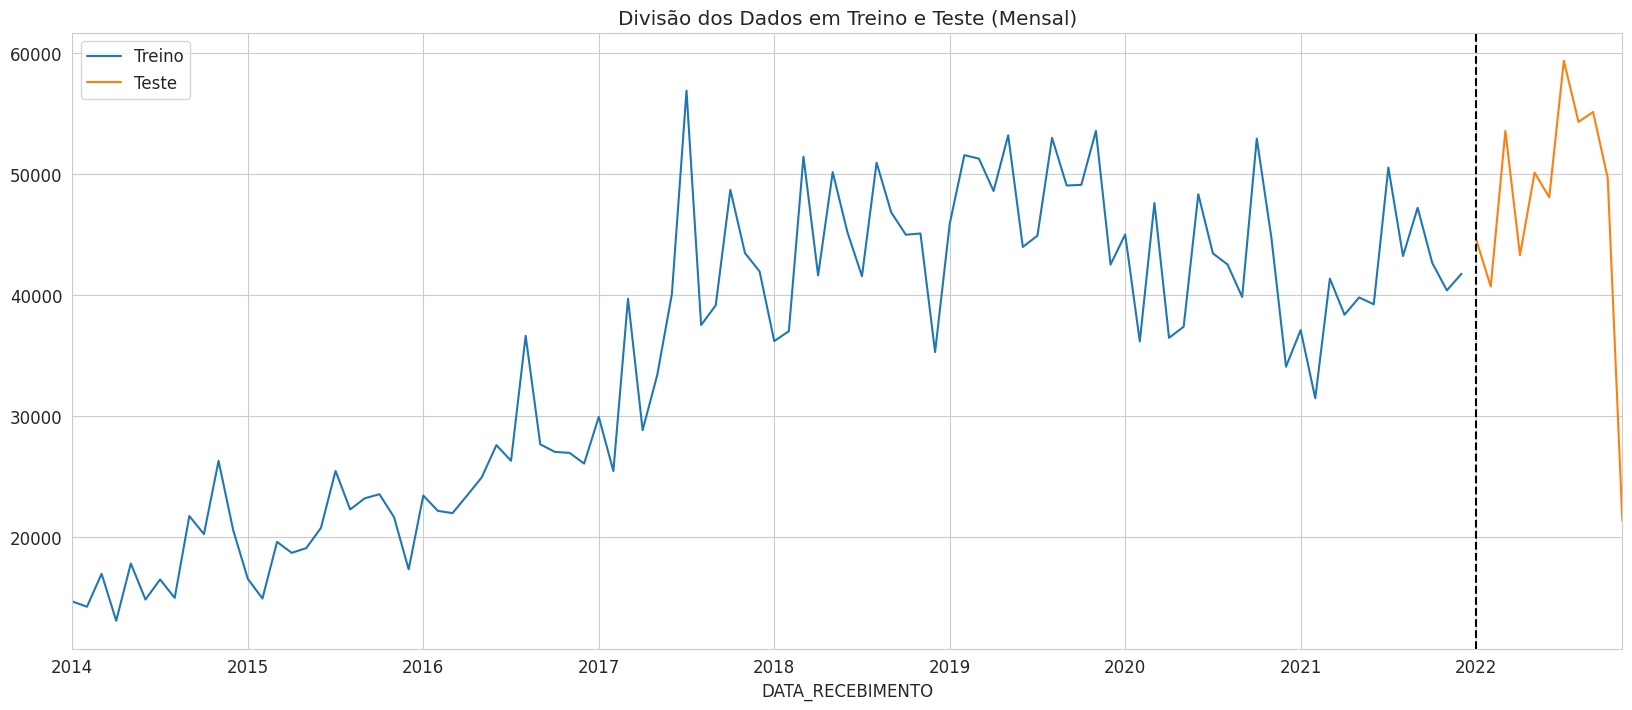

In [23]:
# Importar bibliotecas adicionais para modelagem
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Configurações de visualização
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (20, 8)

# Carregar o dataset preparado na etapa anterior
caminho_arquivo_preparado = "/home/lucala/Residencia TJGO/tjgo/NLP/ENTREGAS FINAL/forecast/data/processed/dados_civel_preparado.csv"
df_diario = pd.read_csv(caminho_arquivo_preparado, index_col='DATA_RECEBIMENTO', parse_dates=True)

# --- LINHA CORRIGIDA ---
# Selecionamos apenas a coluna 'contagem_casos' para a agregação mensal.
df_mensal = df_diario[['contagem_casos']].resample('M').sum().fillna(0)

print("Dataset preparado (mensal) carregado:")
display(df_mensal.head())

# --- Geração do Plano de Teste (Implementação) ---
# Dividir os dados em treino (até o fim de 2021) e teste (dados de 2022)
DATA_CORTE = '2022-01-01'
treino = df_mensal.loc[df_mensal.index < DATA_CORTE]
teste = df_mensal.loc[df_mensal.index >= DATA_CORTE]

print(f"\nDados de treino: de {treino.index.min().date()} a {treino.index.max().date()} ({len(treino)} meses)")
print(f"Dados de teste: de {teste.index.min().date()} a {teste.index.max().date()} ({len(teste)} meses)")

# Plotar a divisão para visualização
fig, ax = plt.subplots()
treino['contagem_casos'].plot(ax=ax, label='Treino')
teste['contagem_casos'].plot(ax=ax, label='Teste')
ax.axvline(pd.to_datetime(DATA_CORTE), color='black', ls='--')
plt.title('Divisão dos Dados em Treino e Teste (Mensal)')
plt.legend()
plt.show()

In [24]:
# --- Modelo 1: Baseline (Previsão Ingênua Sazonal Mensal) ---
# A previsão para um mês é o valor de 12 meses antes.

# Criar a previsão usando o método shift para deslocar os dados em 12 meses
previsao_baseline = treino['contagem_casos'].shift(12, freq='M')

# Pegar apenas as previsões que correspondem ao período de teste
previsao_baseline = previsao_baseline.loc[teste.index]

# Avaliar o modelo
mae_baseline = mean_absolute_error(teste['contagem_casos'], previsao_baseline)
rmse_baseline = np.sqrt(mean_squared_error(teste['contagem_casos'], previsao_baseline))

print("--- Avaliação do Modelo Baseline (Mensal) ---")
print(f"MAE (Erro Absoluto Médio): {mae_baseline:.2f} casos")
print(f"RMSE (Raiz do Erro Quadrático Médio): {rmse_baseline:.2f} casos")

# Guardar os resultados para comparação
resultados = {
    'Baseline': {'MAE': mae_baseline, 'RMSE': rmse_baseline}
}

--- Avaliação do Modelo Baseline (Mensal) ---
MAE (Erro Absoluto Médio): 9720.09 casos
RMSE (Raiz do Erro Quadrático Médio): 10334.75 casos


/tmp/ipykernel_50461/2193152419.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  previsao_baseline = treino['contagem_casos'].shift(12, freq='M')


In [25]:
# --- Modelo 2: SARIMA (Ajustado para Sazonalidade Anual) ---
# m=12 indica uma sazonalidade anual, que é a mais comum em dados mensais.

# Instanciar e treinar o modelo
# Nota: Este modelo pode levar alguns instantes para treinar.
modelo_sarima = SARIMAX(treino['contagem_casos'], 
                        order=(1, 1, 1), 
                        seasonal_order=(1, 1, 1, 12)) # 'm' agora é 12
resultado_sarima = modelo_sarima.fit(disp=False)

# Fazer a previsão para o período de teste
previsao_sarima = resultado_sarima.predict(start=teste.index[0], end=teste.index[-1])

# Avaliar o modelo
mae_sarima = mean_absolute_error(teste['contagem_casos'], previsao_sarima)
rmse_sarima = np.sqrt(mean_squared_error(teste['contagem_casos'], previsao_sarima))

print("\n--- Avaliação do Modelo SARIMA (Mensal) ---")
print(f"MAE: {mae_sarima:.2f} casos")
print(f"RMSE: {rmse_sarima:.2f} casos")

resultados['SARIMA'] = {'MAE': mae_sarima, 'RMSE': rmse_sarima}

/home/lucala/Residencia TJGO/tjgo/NLP/ENTREGAS FINAL/forecast/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



--- Avaliação do Modelo SARIMA (Mensal) ---
MAE: 5890.24 casos
RMSE: 9849.78 casos


In [26]:
# --- Modelo 2: SARIMA (Ajustado para Sazonalidade Anual) ---
# m=12 indica uma sazonalidade anual, que é a mais comum em dados mensais.

# Instanciar e treinar o modelo
# Nota: Este modelo pode levar alguns instantes para treinar.
modelo_sarima = SARIMAX(treino['contagem_casos'], 
                        order=(1, 1, 1), 
                        seasonal_order=(1, 1, 1, 12)) # 'm' agora é 12
resultado_sarima = modelo_sarima.fit(disp=False)

# Fazer a previsão para o período de teste
previsao_sarima = resultado_sarima.predict(start=teste.index[0], end=teste.index[-1])

# Avaliar o modelo
mae_sarima = mean_absolute_error(teste['contagem_casos'], previsao_sarima)
rmse_sarima = np.sqrt(mean_squared_error(teste['contagem_casos'], previsao_sarima))

print("\n--- Avaliação do Modelo SARIMA (Mensal) ---")
print(f"MAE: {mae_sarima:.2f} casos")
print(f"RMSE: {rmse_sarima:.2f} casos")

resultados['SARIMA'] = {'MAE': mae_sarima, 'RMSE': rmse_sarima}


--- Avaliação do Modelo SARIMA (Mensal) ---
MAE: 5890.24 casos
RMSE: 9849.78 casos


/home/lucala/Residencia TJGO/tjgo/NLP/ENTREGAS FINAL/forecast/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [29]:
# --- Modelo 3: XGBoost com Features de Calendário Mensais (Sintaxe Moderna) ---

# Recriar as features de calendário para os dataframes de treino e teste
treino['ano'] = treino.index.year
treino['mes'] = treino.index.month

teste['ano'] = teste.index.year
teste['mes'] = teste.index.month

# Definir as features e a variável alvo
FEATURES = ['ano', 'mes']
TARGET = 'contagem_casos'

X_treino = treino[FEATURES]
y_treino = treino[TARGET]

X_teste = teste[FEATURES]
y_teste = teste[TARGET]

# Instanciar e treinar o modelo com a sintaxe moderna para early stopping
modelo_xgb = xgb.XGBRegressor(n_estimators=1000,
                              learning_rate=0.01,
                              early_stopping_rounds=10, # Este argumento funcionará após a atualização
                              random_state=42)

modelo_xgb.fit(X_treino, y_treino,
               eval_set=[(X_teste, y_teste)],
               verbose=False)

# Fazer a previsão
previsao_xgb = modelo_xgb.predict(X_teste)

# Avaliar o modelo
mae_xgb = mean_absolute_error(y_teste, previsao_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_teste, previsao_xgb))

print("\n--- Avaliação do Modelo XGBoost (Mensal) ---")
print(f"MAE: {mae_xgb:.2f} casos")
print(f"RMSE: {rmse_xgb:.2f} casos")

# Adicionar ao dicionário de resultados
if 'resultados' not in locals():
    resultados = {}
resultados['XGBoost'] = {'MAE': mae_xgb, 'RMSE': rmse_xgb}

/tmp/ipykernel_50461/2868447704.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treino['ano'] = treino.index.year
/tmp/ipykernel_50461/2868447704.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treino['mes'] = treino.index.month
/tmp/ipykernel_50461/2868447704.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_


--- Avaliação do Modelo XGBoost (Mensal) ---
MAE: 9750.99 casos
RMSE: 10386.49 casos



--- Tabela Comparativa de Performance dos Modelos (Mensal) ---


,MAE,RMSE
SARIMA,5890.241097,9849.777167
Baseline,9720.090909,10334.748900
XGBoost,9750.991211,10386.493152


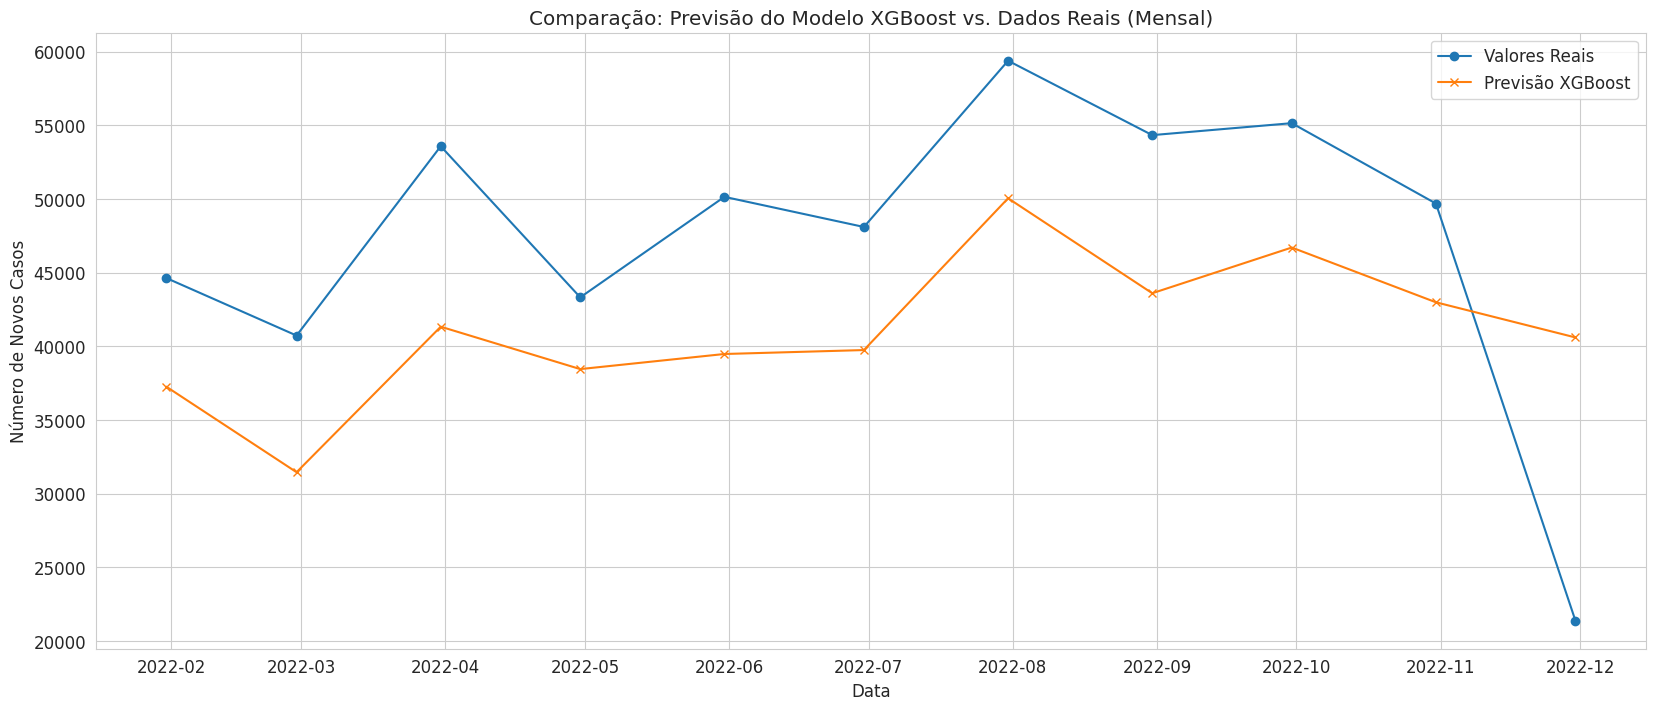

In [30]:
# Criar um DataFrame com os resultados para fácil comparação
df_resultados = pd.DataFrame(resultados).T.sort_values('MAE')

print("\n--- Tabela Comparativa de Performance dos Modelos (Mensal) ---")
display(df_resultados)

# Plotar as previsões do melhor modelo contra os dados reais
plt.figure(figsize=(20, 8))
plt.plot(teste.index, teste['contagem_casos'], label='Valores Reais', marker='o')
plt.plot(teste.index, previsao_xgb, label='Previsão XGBoost', marker='x')
plt.title('Comparação: Previsão do Modelo XGBoost vs. Dados Reais (Mensal)')
plt.ylabel('Número de Novos Casos')
plt.xlabel('Data')
plt.legend()
plt.show()